<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Transfer%20Learning/Transfer_Learning_in_TensorFlow_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Introduction to Transfer Learning - Feature Extraction

In [1]:
!nvidia-smi

Sat Jan 14 05:14:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Downloading and becoming one with data

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-14 05:14:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   203MB/s    in 0.8s    

2023-01-14 05:14:22 (203 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print("There are ",len(dirnames)," directories",len(filenames)," in ",dirpath)

There are  2  directories 0  in  10_food_classes_10_percent
There are  10  directories 0  in  10_food_classes_10_percent/test
There are  0  directories 250  in  10_food_classes_10_percent/test/sushi
There are  0  directories 250  in  10_food_classes_10_percent/test/ice_cream
There are  0  directories 250  in  10_food_classes_10_percent/test/hamburger
There are  0  directories 250  in  10_food_classes_10_percent/test/pizza
There are  0  directories 250  in  10_food_classes_10_percent/test/chicken_wings
There are  0  directories 250  in  10_food_classes_10_percent/test/grilled_salmon
There are  0  directories 250  in  10_food_classes_10_percent/test/fried_rice
There are  0  directories 250  in  10_food_classes_10_percent/test/ramen
There are  0  directories 250  in  10_food_classes_10_percent/test/steak
There are  0  directories 250  in  10_food_classes_10_percent/test/chicken_curry
There are  10  directories 0  in  10_food_classes_10_percent/train
There are  0  directories 75  in  10_fo

## 2. Creating data loaders

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,target_size = IMAGE_SHAPE,batch_size = BATCH_SIZE,class_mode = "sparse")

Found 750 images belonging to 10 classes.


In [7]:
test_data = test_datagen.flow_from_directory(test_dir,target_size = IMAGE_SHAPE,batch_size = BATCH_SIZE,class_mode = "sparse")

Found 2500 images belonging to 10 classes.


## 3.Setting Up Callbacks

### Tensorboard Callback

In [8]:
 ## Creating tensorboard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%D-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print("Saving Tensorflow log files to: ",log_dir)
  return tensorboard_callback


## Creating Models Using TensorFlow Hub

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [11]:
def create_model(model_url,max_classes = 10):
  """
  Takes a tensorflow hub url and creates a keras sequential model with it.
  """
  feature_extractor_layer = hub.KerasLayer(model_url,trainable = False,name = "feature_extraction_layer",input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(max_classes,activation = "softmax",name = "output_layer")
  ])
  return model

### Resnet Model

In [12]:
resnet_model = create_model(resnet_url,10)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = "adam",metrics = ["accuracy"])

In [15]:
history_1 = resnet_model.fit(train_data,steps_per_epoch = len(train_data),epochs = 5 ,validation_data = test_data,validation_steps = len(test_data),callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",experiment_name = "resnet_v2_50")])

Saving Tensorflow log files to:  tensorflow_hub/resnet_v2_50/20230101/14/23-051433
Epoch 1/5
24/24 [==============================] - 32s 748ms/step - loss: 1.9531 - accuracy: 0.3373 - val_loss: 1.2231 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 16s 697ms/step - loss: 0.8879 - accuracy: 0.7453 - val_loss: 0.8695 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 15s 663ms/step - loss: 0.6117 - accuracy: 0.8333 - val_loss: 0.7568 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 15s 663ms/step - loss: 0.4710 - accuracy: 0.8867 - val_loss: 0.7022 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.3656 - accuracy: 0.9200 - val_loss: 0.6816 - val_accuracy: 0.7828


In [16]:
import matplotlib.pyplot as plt
## Plot loss Cuves
def plot_loss_curves(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))
  #Plot Loss
  plt.plot(epochs,loss,label = "training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label = "training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

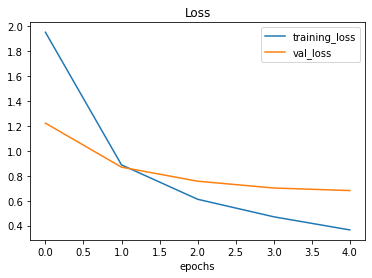

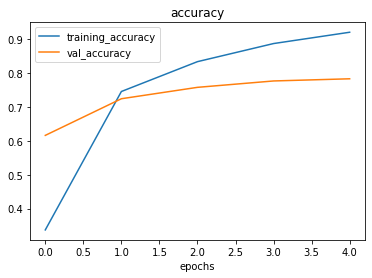

In [17]:
plot_loss_curves(history_1)

### EfficientNet Model

In [18]:
efficientnet_model = create_model(efficient_url,10)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [20]:
efficientnet_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [21]:
history_2  = efficientnet_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),callbacks = [create_tensorboard_callback(
        dir_name = "tensorflow_hub",
        experiment_name = "efficientnetb0"
    )])

Saving Tensorflow log files to:  tensorflow_hub/efficientnetb0/20230101/14/23-051619
Epoch 1/5
24/24 [==============================] - 25s 708ms/step - loss: 1.8571 - accuracy: 0.4307 - val_loss: 1.3140 - val_accuracy: 0.7308
Epoch 2/5
24/24 [==============================] - 15s 643ms/step - loss: 1.0659 - accuracy: 0.7720 - val_loss: 0.8741 - val_accuracy: 0.8104
Epoch 3/5
24/24 [==============================] - 15s 637ms/step - loss: 0.7576 - accuracy: 0.8240 - val_loss: 0.7047 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.6093 - accuracy: 0.8640 - val_loss: 0.6165 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 15s 635ms/step - loss: 0.5153 - accuracy: 0.8893 - val_loss: 0.5637 - val_accuracy: 0.8548


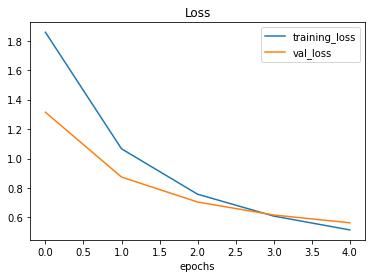

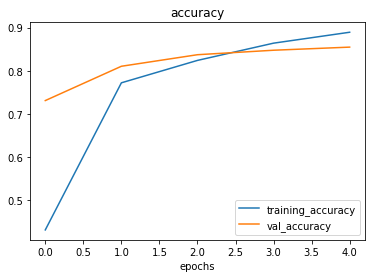

In [22]:
plot_loss_curves(history_2)

## Comparing Results using TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs ResNet50V2" \
 --description "Comparing EfficientNet and ResNet Architecture using 10 % of training data" \
 --one_shot

In [25]:
!tensorboard dev list

https://tensorboard.dev/experiment/0zdJKuGgSBefyNjiy8zzLA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing EfficientNet and ResNet Architecture using 10 % of training data
	Id                   0zdJKuGgSBefyNjiy8zzLA
	Created              2023-01-14 05:26:03 (4 minutes ago)
	Updated              2023-01-14 05:26:05 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5908816
Total: 1 experiment(s)
